# Re-hospitalization of Diabetic Patients

In [1]:
# Import all libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext
from pyspark.ml import feature
from pyspark.ml import regression
from pyspark.sql import functions as fn
from pyspark.sql.functions import countDistinct
from pyspark.sql import Row
from pyspark import sql
import seaborn as sns
from pyspark.ml import feature, regression, evaluation, Pipeline
from pyspark.ml.feature import StringIndexer
from pyspark.ml import clustering
from pyspark.ml import classification
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator, \
    MulticlassClassificationEvaluator, \
    RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import seaborn as sns
import decimal
from pyspark.sql.types import StructType
from pyspark.sql.types import *
from pyspark.ml.feature import StandardScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.classification import GBTClassifier

In [2]:
# Downloading the csv file 
df_spark = spark.read.csv("diabetic_data.csv",header=True)
#df_pandas = df_spark.toPandas()
#df_pandas.head(5)

In [3]:
# Dimension
#df_pandas.shape
backup = df_spark

# Data Cleaning and Pre-processing

## Removal of columns

In [4]:
# Removing Weight, Payer Code and Medical speciality of the surgeon as they have 80-90% missing values
drop_list = ['weight', 'payer_code','medical_specialty','citoglipton','examide']
df_spark = df_spark.select([column for column in df_spark.columns if column not in drop_list])

## Removal of rows

In [5]:
#Removing rows from Race,Discharge Disposition ID,Admission Source ID, Admission type ID
df_spark = df_spark.filter(df_spark.race!='?')
df_spark = df_spark.filter(df_spark.diag_1!='?')
df_spark = df_spark.filter(df_spark.diag_2!='?')
df_spark = df_spark.filter(df_spark.diag_3!='?')
df_spark = df_spark.filter(df_spark.discharge_disposition_id.isin(['11' '18','19','20','25'])==False)
df_spark = df_spark.filter(df_spark.admission_source_id.isin(['9','17','20'])==False)
df_spark = df_spark.filter(df_spark.admission_type_id.isin(['5','6','8'])==False)

# df_spark = df_spark.filter(df_spark["diag_1"].rlike("[A-za-z][^A-Za-z]*")==False)
# df_spark = df_spark.filter(df_spark["diag_2"].rlike("[A-za-z][^A-Za-z]*")==False)
# df_spark = df_spark.filter(df_spark["diag_3"].rlike("[A-za-z][^A-Za-z]*")==False)

# df_spark.select('race','discharge_disposition_id','admission_type_id','admission_source_id').toPandas().head(5)

## Changing Data Types

In [6]:
# Changing Data type of patient nbr and encounter_id to int
df_spark = df_spark.withColumn("patient_nbr", df_spark["patient_nbr"].cast(IntegerType()))
df_spark = df_spark.withColumn("encounter_id", df_spark["encounter_id"].cast(IntegerType()))

In [7]:
# Changing Data type of admission_type_id,discharge_disposition_id and ..... nbr and encounter_id to float
df_spark_clean1 = df_spark.select("encounter_id","patient_nbr",*(fn.col(c).cast("float").alias(c) for c in df_spark.columns 
                                 if c in ('admission_source_id','admission_type_id','discharge_disposition_id','time_in_hospital',
                                         'num_procedures','num_lab_procedures','num_medications','number_outpatient','number_emergency',
                                        'number_inpatient','number_diagnoses' )))

In [8]:
df_spark_clean1.dtypes

[('encounter_id', 'int'),
 ('patient_nbr', 'int'),
 ('admission_type_id', 'float'),
 ('discharge_disposition_id', 'float'),
 ('admission_source_id', 'float'),
 ('time_in_hospital', 'float'),
 ('num_lab_procedures', 'float'),
 ('num_procedures', 'float'),
 ('num_medications', 'float'),
 ('number_outpatient', 'float'),
 ('number_emergency', 'float'),
 ('number_inpatient', 'float'),
 ('number_diagnoses', 'float')]

## Joining two dataframes

In [9]:
# Merging df_spark_clean and df_spark to get the entire cleaned dataset
drop_list = ['admission_type_id','discharge_disposition_id',
             'admission_source_id','time_in_hospital','num_lab_procedures',
             'num_procedures','num_medications','number_outpatient','number_emergency',
             'number_inpatient','number_diagnoses','patient_nbr']
diabetic_data_clean2 = df_spark.select([column for column in df_spark.columns if column not in drop_list])

df_spark = df_spark_clean1.join(diabetic_data_clean2, 'encounter_id', 'inner')

In [10]:
df_spark.createOrReplaceTempView("temp") 

# Feature Engineering

## Creating Dummy variables for categorical columns

In [11]:
# Creating dummy variables for admission_type_id
df_spark = df_spark.withColumn('admission_type_emergency',fn.when(fn.col('admission_type_id')==1,1).otherwise(0))
df_spark = df_spark.withColumn('admission_type_urgent',fn.when(fn.col('admission_type_id')==2,1).otherwise(0))
df_spark = df_spark.withColumn('admission_type_elective',fn.when(fn.col('admission_type_id')==3,1).otherwise(0))
df_spark = df_spark.withColumn('admission_type_trauma',fn.when(fn.col('admission_type_id')==7,1).otherwise(0))

#df_spark_final.select('admission_type_emergency','admission_type_urgent','admission_type_elective','admission_type_trauma').show(5)

In [12]:
# Creating dummy variables for discharge_disposition_id
df_spark = df_spark.withColumn('dd_home',fn.when(fn.col('discharge_disposition_id')==1,1).otherwise(0))
df_spark = df_spark.withColumn('dd_shortm_hos',fn.when(fn.col('discharge_disposition_id')==2,1).otherwise(0))
df_spark = df_spark.withColumn('dd_snf',fn.when(fn.col('discharge_disposition_id')==3,1).otherwise(0))
df_spark = df_spark.withColumn('dd_icf',fn.when(fn.col('discharge_disposition_id')==4,1).otherwise(0))
df_spark = df_spark.withColumn('dd_careInst',fn.when(fn.col('discharge_disposition_id')==5,1).otherwise(0))
df_spark = df_spark.withColumn('dd_hhs',fn.when(fn.col('discharge_disposition_id')==6,1).otherwise(0))
df_spark = df_spark.withColumn('dd_ama',fn.when(fn.col('discharge_disposition_id')==7,1).otherwise(0))
df_spark = df_spark.withColumn('dd_homeIvy',fn.when(fn.col('discharge_disposition_id')==8,1).otherwise(0))
df_spark = df_spark.withColumn('dd_admInp',fn.when(fn.col('discharge_disposition_id')==9,1).otherwise(0))
df_spark = df_spark.withColumn('dd_expired',fn.when(fn.col('discharge_disposition_id')==11,1).otherwise(0))
df_spark = df_spark.withColumn('dd_hospice',fn.when(fn.col('discharge_disposition_id')==13,1).otherwise(0))
df_spark = df_spark.withColumn('dd_medfac',fn.when(fn.col('discharge_disposition_id')==14,1).otherwise(0))
df_spark = df_spark.withColumn('dd_swingbed',fn.when(fn.col('discharge_disposition_id')==15,1).otherwise(0))
df_spark = df_spark.withColumn('dd_rehab',fn.when(fn.col('discharge_disposition_id')==22,1).otherwise(0))
df_spark = df_spark.withColumn('dd_long',fn.when(fn.col('discharge_disposition_id')==23,1).otherwise(0))
df_spark = df_spark.withColumn('dd_nursing',fn.when(fn.col('discharge_disposition_id')==24,1).otherwise(0))
df_spark = df_spark.withColumn('dd_federal',fn.when(fn.col('discharge_disposition_id')==27,1).otherwise(0))
df_spark = df_spark.withColumn('dd_psy',fn.when(fn.col('discharge_disposition_id')==28,1).otherwise(0))

In [13]:
# Creating dummy variables for admission_source_id
df_spark = df_spark.withColumn('admission_source_phyref',fn.when(fn.col('admission_source_id')==1,1).otherwise(0))
df_spark = df_spark.withColumn('admission_source_cliref',fn.when(fn.col('admission_source_id')==2,1).otherwise(0))
df_spark = df_spark.withColumn('admission_source_hmoref',fn.when(fn.col('admission_source_id')==3,1).otherwise(0))
df_spark = df_spark.withColumn('admission_source_hos',fn.when(fn.col('admission_source_id')==4,1).otherwise(0))
df_spark = df_spark.withColumn('admission_source_snf',fn.when(fn.col('admission_source_id')==5,1).otherwise(0))
df_spark = df_spark.withColumn('admission_source_hlthcare',fn.when(fn.col('admission_source_id')==6,1).otherwise(0))
df_spark = df_spark.withColumn('admission_source_emergency',fn.when(fn.col('admission_source_id')==7,1).otherwise(0))
df_spark = df_spark.withColumn('admission_source_court',fn.when(fn.col('admission_source_id')==8,1).otherwise(0))
df_spark = df_spark.withColumn('admission_source_critical',fn.when(fn.col('admission_source_id')==10,1).otherwise(0))
df_spark = df_spark.withColumn('admission_source_normdel',fn.when(fn.col('admission_source_id')==11,1).otherwise(0))
df_spark = df_spark.withColumn('admission_source_birth',fn.when(fn.col('admission_source_id')==14,1).otherwise(0))
df_spark = df_spark.withColumn('admission_source_surgery',fn.when(fn.col('admission_source_id')==25,1).otherwise(0))


In [14]:
# Creating dummy variables for race
df_spark = df_spark.withColumn('AfricanAmerican',fn.when(fn.col('race')=='AfricanAmerican',1).otherwise(0))
df_spark = df_spark.withColumn('Asian',fn.when(fn.col('race')=='Asian',1).otherwise(0))
df_spark = df_spark.withColumn('Caucasian',fn.when(fn.col('race')=='Caucasian',1).otherwise(0))
df_spark = df_spark.withColumn('Hispanic',fn.when(fn.col('race')=='Hispanic',1).otherwise(0))

# df_spark.select('AfricanAmerican','Asian','Caucasian','Hispanic','Other').show(5)

In [15]:
# Creating dummy variables for gender
df_spark = df_spark.withColumn('gender_male',fn.when(fn.col('gender')=='Male',1).otherwise(0))

In [16]:
# Grouped all the different types of diganosis based on their diag values specificed by the mapping document
# Created dummy variables for each category

df_spark = df_spark.withColumn('diag1_Circulatory',
fn.when((df_spark['diag_1'] >= 390) & (df_spark['diag_1'] <= 459) | (df_spark['diag_1'] == 785), 1).otherwise(0))

df_spark = df_spark.withColumn('diag1_Respiratory',
fn.when((df_spark['diag_1'] >= 460) & (df_spark['diag_1'] <= 519) | (df_spark['diag_1'] == 786), 1).otherwise(0))

df_spark = df_spark.withColumn('diag1_Digestive',
fn.when((df_spark['diag_1'] >= 520) & (df_spark['diag_1'] <= 579) | (df_spark['diag_1'] == 787), 1).otherwise(0))
  
df_spark = df_spark.withColumn('diag1_Diabetes', 
fn.when((df_spark['diag_1'] >= 250.00) & (df_spark['diag_1'] <= 250.99), 1).otherwise(0))

df_spark = df_spark.withColumn('diag1_Injury', 
fn.when((df_spark['diag_1'] >= 800) & (df_spark['diag_1'] <= 999), 1).otherwise(0))

df_spark = df_spark.withColumn('diag1_Musculoskeletal', 
fn.when((df_spark['diag_1'] >= 710) & (df_spark['diag_1'] <= 739), 1).otherwise(0))

df_spark = df_spark.withColumn('diag1_Genitourinary',
fn.when((df_spark['diag_1'] >= 580) & (df_spark['diag_1'] <= 629) | (df_spark['diag_1'] == 788), 1).otherwise(0))


df_spark = df_spark.withColumn('diag1_Neoplasms',
fn.when(((df_spark['diag_1'] >= 1) & (df_spark['diag_1'] <= 249)) | (df_spark['diag_1'] == 780) |
    (df_spark['diag_1'] == 781) | (df_spark['diag_1'] == 782) | (df_spark['diag_1'] == 784) |
        ((df_spark['diag_1'] >= 251) & (df_spark['diag_1'] <= 279)) | 
        ((df_spark['diag_1'] >= 680) & (df_spark['diag_1'] <= 709)) | 
        ((df_spark['diag_1'] >= 790) & (df_spark['diag_1'] <= 799)), 1).otherwise(0))


In [17]:
df_spark = df_spark.withColumn('diag2_Circulatory',
fn.when((df_spark['diag_2'] >= 390) & (df_spark['diag_2'] <= 459) | (df_spark['diag_2'] == 785), 1).otherwise(0))

df_spark = df_spark.withColumn('diag2_Respiratory',
fn.when((df_spark['diag_2'] >= 460) & (df_spark['diag_2'] <= 519) | (df_spark['diag_2'] == 786), 1).otherwise(0))

df_spark = df_spark.withColumn('diag2_Digestive',
fn.when((df_spark['diag_2'] >= 520) & (df_spark['diag_2'] <= 579) | (df_spark['diag_2'] == 787), 1).otherwise(0))
  
df_spark = df_spark.withColumn('diag2_Diabetes', 
fn.when((df_spark['diag_2'] >= 250.00) & (df_spark['diag_2'] <= 250.99), 1).otherwise(0))

df_spark = df_spark.withColumn('diag2_Injury', 
fn.when((df_spark['diag_2'] >= 800) & (df_spark['diag_2'] <= 999), 1).otherwise(0))

df_spark = df_spark.withColumn('diag2_Musculoskeletal', 
fn.when((df_spark['diag_2'] >= 710) & (df_spark['diag_2'] <= 739), 1).otherwise(0))

df_spark = df_spark.withColumn('diag2_Genitourinary',
fn.when((df_spark['diag_2'] >= 580) & (df_spark['diag_2'] <= 629) | (df_spark['diag_2'] == 788), 1).otherwise(0))


df_spark = df_spark.withColumn('diag2_Neoplasms',
fn.when(((df_spark['diag_2'] >= 1) & (df_spark['diag_2'] <= 249)) | (df_spark['diag_2'] == 780) |
    (df_spark['diag_2'] == 781) | (df_spark['diag_2'] == 782) | (df_spark['diag_2'] == 784) |
        ((df_spark['diag_2'] >= 251) & (df_spark['diag_2'] <= 279)) | 
        ((df_spark['diag_2'] >= 680) & (df_spark['diag_2'] <= 709)) | 
        ((df_spark['diag_2'] >= 790) & (df_spark['diag_2'] <= 799)), 1).otherwise(0))


In [18]:
df_spark = df_spark.withColumn('diag3_Circulatory',
fn.when((df_spark['diag_3'] >= 390) & (df_spark['diag_3'] <= 459) | (df_spark['diag_3'] == 785), 1).otherwise(0))

df_spark = df_spark.withColumn('diag3_Respiratory',
fn.when((df_spark['diag_3'] >= 460) & (df_spark['diag_3'] <= 519) | (df_spark['diag_3'] == 786), 1).otherwise(0))

df_spark = df_spark.withColumn('diag3_Digestive',
fn.when((df_spark['diag_3'] >= 520) & (df_spark['diag_3'] <= 579) | (df_spark['diag_3'] == 787), 1).otherwise(0))
  
df_spark = df_spark.withColumn('diag3_Diabetes', 
fn.when((df_spark['diag_3'] >= 250.00) & (df_spark['diag_3'] <= 250.99), 1).otherwise(0))

df_spark = df_spark.withColumn('diag3_Injury', 
fn.when((df_spark['diag_3'] >= 800) & (df_spark['diag_3'] <= 999), 1).otherwise(0))

df_spark = df_spark.withColumn('diag3_Musculoskeletal', 
fn.when((df_spark['diag_3'] >= 710) & (df_spark['diag_3'] <= 739), 1).otherwise(0))

df_spark = df_spark.withColumn('diag3_Genitourinary',
fn.when((df_spark['diag_3'] >= 580) & (df_spark['diag_3'] <= 629) | (df_spark['diag_3'] == 788), 1).otherwise(0))


df_spark = df_spark.withColumn('diag3_Neoplasms',
fn.when(((df_spark['diag_3'] >= 1) & (df_spark['diag_3'] <= 249)) | (df_spark['diag_3'] == 780) |
    (df_spark['diag_3'] == 781) | (df_spark['diag_3'] == 782) | (df_spark['diag_3'] == 784) |
        ((df_spark['diag_3'] >= 251) & (df_spark['diag_3'] <= 279)) | 
        ((df_spark['diag_3'] >= 680) & (df_spark['diag_3'] <= 709)) | 
        ((df_spark['diag_3'] >= 790) & (df_spark['diag_3'] <= 799)), 1).otherwise(0))


In [19]:
# Creating dummy variables for max_glu_serum
df_spark = df_spark.withColumn('max_glu_200',fn.when(fn.col('max_glu_serum')=='>200',1).otherwise(0))
df_spark = df_spark.withColumn('max_glu_300',fn.when(fn.col('max_glu_serum')=='>300',1).otherwise(0))
df_spark = df_spark.withColumn('max_glu_norm',fn.when(fn.col('max_glu_serum')=='Norm',1).otherwise(0))
#df_spark_final.select('max_glu_none','max_glu_200','max_glu_300','max_glu_norm').show(10)


In [20]:
# Creating dummy variables for A1Cresult
df_spark = df_spark.withColumn('A1Cresult_7',fn.when(fn.col('A1Cresult')=='>7',1).otherwise(0))
df_spark = df_spark.withColumn('A1Cresult_8',fn.when(fn.col('A1Cresult')=='>8',1).otherwise(0))
df_spark = df_spark.withColumn('A1Cresult_norm',fn.when(fn.col('A1Cresult')=='Norm',1).otherwise(0))
#df_spark_final.select('max_glu_none','max_glu_7','max_glu_8','max_glu_norm').show(10)

In [21]:
# Creating dummy variables for change and diabetesMed
df_spark = df_spark.withColumn('change',fn.when(fn.col('change')=='Ch',1).otherwise(0))
df_spark = df_spark.withColumn('diabetesMed',fn.when(fn.col('diabetesMed')=='Yes',1).otherwise(0))
#df_spark.select('change','diabetesMed').show(10)

In [22]:
# Creating dummy variables for readmitted
df_spark = df_spark.withColumn('readmitted',fn.when(df_spark["readmitted"] == 'NO', 0).otherwise(1))

## Treating all ordinal columns by using String Indexer

In [23]:
# Converting all the 24 medicines
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(df_spark)\
            for column in ('metformin','repaglinide','nateglinide')]

pipeline = Pipeline(stages=indexers)
df_spark = pipeline.fit(df_spark).transform(df_spark)

In [24]:
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(df_spark)\
            for column in ('chlorpropamide','glimepiride','acetohexamide')]

pipeline = Pipeline(stages=indexers)
df_spark = pipeline.fit(df_spark).transform(df_spark)

In [25]:
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(df_spark)\
            for column in ('miglitol','troglitazone','tolazamide')]


pipeline = Pipeline(stages=indexers)
df_spark = pipeline.fit(df_spark).transform(df_spark)

In [26]:
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(df_spark)\
            for column in ('insulin','glyburide-metformin','glipizide-metformin')]

pipeline = Pipeline(stages=indexers)
df_spark = pipeline.fit(df_spark).transform(df_spark)

In [27]:
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(df_spark)\
            for column in ('glimepiride-pioglitazone','metformin-rosiglitazone','metformin-pioglitazone')]


pipeline = Pipeline(stages=indexers)
df_spark = pipeline.fit(df_spark).transform(df_spark)

In [28]:
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(df_spark)\
            for column in ('glipizide','glyburide','tolbutamide')]

pipeline = Pipeline(stages=indexers)
df_spark = pipeline.fit(df_spark).transform(df_spark)

In [29]:
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(df_spark)\
            for column in ('pioglitazone','rosiglitazone','acarbose')]

pipeline = Pipeline(stages=indexers)
df_spark = pipeline.fit(df_spark).transform(df_spark)

In [30]:
df_spark = df_spark.withColumn('insulin_index1',fn.when(df_spark["insulin_index"]==2,4).\
                                           otherwise(df_spark["insulin_index"]))
df_spark = df_spark.withColumn('insulin_index1',fn.when(df_spark["insulin_index1"]==3,2).\
                                           otherwise(df_spark["insulin_index1"]))
df_spark = df_spark.drop('insulin_index')
df_spark = df_spark.withColumn('insulin_index',fn.when(df_spark["insulin_index1"]==4,3).\
                                           otherwise(df_spark["insulin_index1"]))
df_spark = df_spark.drop('insulin_index1')

In [31]:
df_spark = df_spark.withColumn('miglitol_index1',fn.when(df_spark["miglitol_index"]==2,4).\
                                           otherwise(df_spark["miglitol_index"]))
df_spark = df_spark.withColumn('miglitol_index1',fn.when(df_spark["miglitol_index1"]==3,2).\
                                           otherwise(df_spark["miglitol_index1"]))
df_spark = df_spark.drop('miglitol_index')
df_spark = df_spark.withColumn('miglitol_index',fn.when(df_spark["miglitol_index1"]==4,3).\
                                           otherwise(df_spark["miglitol_index1"]))
df_spark = df_spark.drop('miglitol_index1')

## Creating new column total_visits = number_inpatient + number_outpatient

In [32]:
dfsum = fn.col('number_outpatient') + fn.col('number_inpatient')
df_spark = df_spark.withColumn('total_visits',dfsum)

## Taking square root and log transformation of right-skewed distributions

Text(0.5,0,'total_visits')

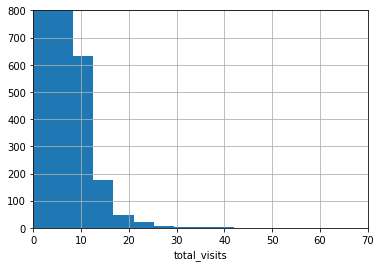

In [33]:
df_spark.select('total_visits').toPandas().total_visits.hist()
plt.xlim(0,70)
plt.ylim(0,800)
plt.xlabel('total_visits')

Text(0.5,0,'number_emergency')

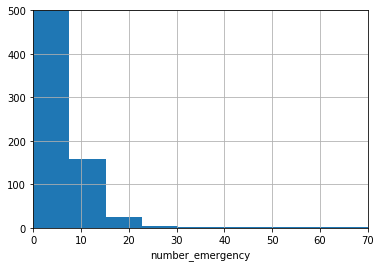

In [34]:
df_spark.select('number_emergency').toPandas().number_emergency.hist()
plt.xlim(0,70)
plt.ylim(0,500)
plt.xlabel('number_emergency')

Text(0.5,0,'time_in_hospital')

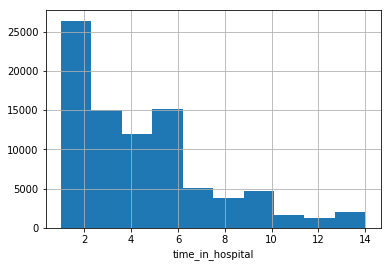

In [35]:
df_spark.select('time_in_hospital').toPandas().time_in_hospital.hist()
plt.xlabel('time_in_hospital')

Text(0.5,0,'num_lab_procedures')

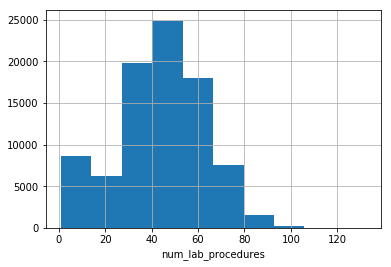

In [36]:
df_spark.select('num_lab_procedures').toPandas().num_lab_procedures.hist()
plt.xlabel('num_lab_procedures')

Text(0.5,0,'num_medications')

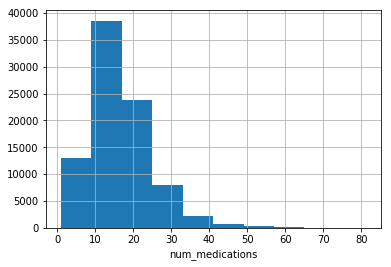

In [37]:
df_spark.select('num_medications').toPandas().num_medications.hist()
plt.xlabel('num_medications')

Text(0.5,0,'num_procedures')

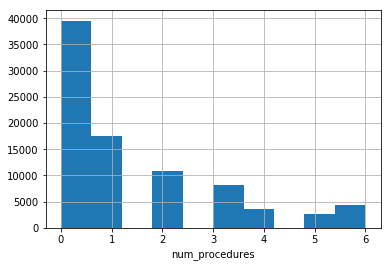

In [38]:
df_spark.select('num_procedures').toPandas().num_procedures.hist()
plt.xlabel('num_procedures')

Text(0.5,0,'number_diagnoses')

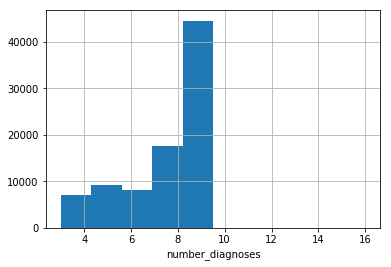

In [39]:
df_spark.select('number_diagnoses').toPandas().number_diagnoses.hist()
plt.xlabel('number_diagnoses')

In [40]:
##SQRT
df_spark = df_spark.withColumn('total_visits_sqrt',fn.round(fn.sqrt(fn.col('total_visits')),2))
df_spark = df_spark.withColumn('number_emergency_sqrt',fn.round(fn.sqrt(fn.col('number_emergency')),2))
df_spark = df_spark.withColumn('num_lab_procedures_sqrt',fn.round(fn.sqrt(fn.col('num_lab_procedures')),2))
df_spark = df_spark.withColumn('num_medications_sqrt',fn.round(fn.sqrt(fn.col('num_medications')),2))

##LOG
df_spark = df_spark.withColumn('total_visits_log',fn.round(fn.log(fn.col('total_visits')+0.01),2))
df_spark = df_spark.withColumn('number_emergency_log',fn.round(fn.log(fn.col('number_emergency')+0.01),2))
df_spark = df_spark.withColumn('num_lab_procedures_log',fn.round(fn.log(fn.col('num_lab_procedures')+0.01),2))
df_spark = df_spark.withColumn('num_medications_log',fn.round(fn.log(fn.col('num_medications')+0.01),2))



In [41]:
# Converting Age into numeric

df_spark = df_spark.withColumn('age',fn.when(df_spark.age=='[0-10)',10).otherwise(df_spark.age))
df_spark = df_spark.withColumn('age',fn.when(df_spark.age=='[10-20)',20).otherwise(df_spark.age))
df_spark = df_spark.withColumn('age',fn.when(df_spark.age=='[20-30)',30).otherwise(df_spark.age))
df_spark = df_spark.withColumn('age',fn.when(df_spark.age=='[30-40)',40).otherwise(df_spark.age))
df_spark = df_spark.withColumn('age',fn.when(df_spark.age=='[40-50)',50).otherwise(df_spark.age))
df_spark = df_spark.withColumn('age',fn.when(df_spark.age=='[50-60)',60).otherwise(df_spark.age))
df_spark = df_spark.withColumn('age',fn.when(df_spark.age=='[60-70)',70).otherwise(df_spark.age))
df_spark = df_spark.withColumn('age',fn.when(df_spark.age=='[70-80)',80).otherwise(df_spark.age))
df_spark = df_spark.withColumn('age',fn.when(df_spark.age=='[80-90)',90).otherwise(df_spark.age))
df_spark = df_spark.withColumn('age',fn.when(df_spark.age=='[90-100)',100).otherwise(df_spark.age))
df_spark = df_spark.withColumn('age',fn.when(df_spark.age=='[100-110)',110).otherwise(df_spark.age))

df_spark.select('age').show(10)

+---+
|age|
+---+
| 20|
| 30|
| 40|
| 50|
| 60|
| 70|
| 80|
| 90|
|100|
| 50|
+---+
only showing top 10 rows



In [42]:
df_spark = df_spark.withColumn("age", df_spark["age"].cast(IntegerType()))

Text(0.5,0,'age')

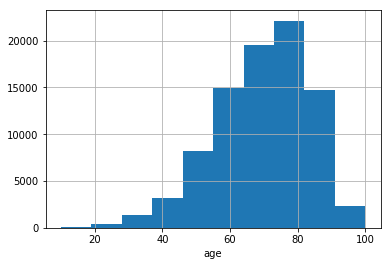

In [43]:
df_spark.select('age').toPandas().age.hist()
plt.xlabel('age')
# Left skewed

# Exploratory Data Analysis

In [44]:
readmitted_count = df_spark.select('readmitted').groupBy('readmitted').count().show()
spark.sql("Select readmitted, count(readmitted),(count(readmitted)*100/(select count(readmitted) from temp)) as Percentage from temp group by readmitted").show()
# 11% of patients were readmitted within 30 days (<30)
# 35% of patients were readmitted after 30 days (>30)
# 54% of patients were never readmitted (NO)

+----------+-----+
|readmitted|count|
+----------+-----+
|         1|40207|
|         0|46654|
+----------+-----+

+----------+-----------------+------------------+
|readmitted|count(readmitted)|        Percentage|
+----------+-----------------+------------------+
|       >30|            30357| 34.94894141214124|
|        NO|            46654| 53.71110164515721|
|       <30|             9850|11.339956942701559|
+----------+-----------------+------------------+



In [45]:
# The response variable 'readmitted' in the original dataset contains three categories.

# a = df_spark.toPandas()
# ax = a['readmitted'].value_counts().plot(kind='barh',figsize=(18,5),title="Count of each admission type")

# totals = []
# for i in ax.patches:
#     totals.append(i.get_width())

# total = sum(totals)

# for i in ax.patches:
#     ax.text(i.get_width()+.3, i.get_y()+.38, \
#             str(round((i.get_width()/total)*100, 2))+'%', fontsize=15,
# color='red')
# ax.invert_yaxis()
# ax.set_xlabel("Re-admission type")
# ax.set_ylabel("Relative Frequency")

In [46]:
# Recode the readmission variable to 1 and 0 to find out correlation with predictor variables
# '0' means no readmission
# '1' means readmission no matter how many days after being discharged
# df_spark_recoded = 1,0
# df_spark = Yes,No

#df_spark_recoded = df_spark.withColumn('readmitted',fn.when(df_spark["readmitted"] == 'NO', 0).otherwise(1))


In [47]:
# df_spark_recoded.createOrReplaceTempView("temp2") 

In [48]:
# corr_matrix = df_spark_recoded.select('num_lab_procedures','num_procedures','num_medications','number_outpatient',
#                               'number_emergency','number_inpatient','number_diagnoses','readmitted')

# pd_corr = corr_matrix.toPandas()
# print(pd_corr.corr())
# sns.heatmap(pd_corr.corr(),square=True,cmap='Oranges')

In [49]:
#color = ['blue', 'red','green','yellow','cyan','purple','black','orange']

In [50]:
# sns.set(style="ticks", color_codes=True)
# sns.pairplot(pd_corr
#              ,hue='readmitted')


In [51]:
#Stacked Bar Graph with Age and Readmitted
# df2 = df_spark.toPandas().groupby(['age', 'readmitted'])['age'].count().unstack('readmitted')
# #df2.head()
# df2[['NO','<30','>30']].plot(kind='bar', stacked=False)

In [52]:
#Stacked Bar Graph with Race and Readmitted
# df2 = df_spark.toPandas().groupby(['race', 'readmitted'])['race'].count().unstack('readmitted')
# df2[['NO','<30','>30']].plot(kind='bar', stacked=False)

In [53]:
#Stacked Bar Graph with Inpatient,Outpatient and Readmitted
# df2 = df_spark.toPandas().groupby(['number_inpatient', 'readmitted'])['number_inpatient'].count().unstack('readmitted')
# df2[['NO','<30','>30']].plot(kind='bar', stacked=False)

In [54]:
#Stacked Bar Graph with Emergency and Readmitted
#df2 = df_spark_recoded.toPandas().groupby(['number_emergency', 'readmitted'])['number_inpatient'].count().unstack('readmitted')
#df2
#df2[[0,1]].plot(kind='bar', stacked=False,logy=True)

In [55]:
#df_spark_recoded.select('metformin').distinct().show()

In [56]:
# #Stacked Bar Graph with diabetesMed and Readmitted
# df2 = df_spark.toPandas().groupby(['diabetesMed', 'diag1_Diabetes','diag2_Diabetes','diag3_Diabetes'])['diabetesMed'].count()
# df2.head(5)
# #df2[['No','Yes']].plot(kind='bar', stacked=False)

In [57]:
#df_spark_clean.limit(20).toPandas()

In [58]:
# all_med = df_spark_clean.select('repaglinide_index',
#  'nateglinide_index',
#  'chlorpropamide_index','acetohexamide_index',
#  'troglitazone_index',
#  'tolazamide_index',
#  'glyburide-metformin_index',
#  'glipizide-metformin_index',
#  'glimepiride-pioglitazone_index',
#  'metformin-rosiglitazone_index',
#  'metformin-pioglitazone_index',
#  'tolbutamide_index',
#  'pioglitazone_index','acarbose_index',
#  'insulin_index','miglitol_index','readmitted')

# all_med_corr = all_med.toPandas()
# print(all_med_corr.corr())
# sns.heatmap(all_med_corr.corr(),square=True,cmap='Oranges')

In [59]:
# medicine_corr = df_spark_clean.select('metformin_index','glipizide_index','glimepiride_index',
#      'glyburide_index','rosiglitazone_index','insulin_index','readmitted')

# med_corr = medicine_corr.toPandas()
# print(med_corr.corr())
# sns.heatmap(med_corr.corr(),square=True,cmap='Oranges')

In [60]:
# corr_list1 = df_spark_clean.select('metformin_index','glipizide_index','glimepiride_index',
#      'glyburide_index','rosiglitazone_index','insulin_index',
#  'diag1_Diabetes')

# corr_l1 = corr_list1.toPandas()
# print(corr_l1.corr())
# sns.heatmap(corr_l1.corr(),square=True,cmap='Oranges')

In [61]:
# diag_list = df_spark_clean.select('diag1_Circulatory',
#  'diag1_Respiratory',
#  'diag1_Digestive',
#  'diag1_Diabetes',
#  'diag1_Injury',
#  'diag1_Musculoskeletal',
#  'diag1_Genitourinary',
#  'diag1_Neoplasms',
#  'diag2_Circulatory',
#  'diag2_Respiratory',
#  'diag2_Digestive',
#  'diag2_Diabetes',
#  'diag2_Injury',
#  'diag2_Musculoskeletal',
#  'diag2_Genitourinary',
#  'diag2_Neoplasms',
#  'diag3_Circulatory',
#  'diag3_Respiratory',
#  'diag3_Digestive',
#  'diag3_Diabetes',
#  'diag3_Injury',
#  'diag3_Musculoskeletal',
#  'diag3_Genitourinary',
#  'diag3_Neoplasms','readmitted')

# diag_corr = diag_list.toPandas()
# print(diag_corr.corr())
# sns.heatmap(diag_corr.corr(),square=True,cmap='Oranges')

## Getting only distinct patients with their first occurence

In [62]:
df_spark.createOrReplaceTempView("temp") 

In [63]:
# spark.sql("Select count(distinct patient_nbr) from temp ").collect()

In [64]:
# print((df_spark.count(), len(df_spark.columns)))

In [65]:
# spark.sql("Select distinct 'encounter_id','patient_nbr','admission_type_id','discharge_disposition_id','admission_source_id',
#  'time_in_hospital', 'num_lab_procedures','num_procedures','num_medications','number_outpatient','number_emergency',
#  'number_inpatient','number_diagnoses','race','gender','age','diag_1','diag_2','diag_3','max_glu_serum',
#  'A1Cresult','metformin','repaglinide','nateglinide','chlorpropamide','glimepiride','acetohexamide',
#  'glipizide','glyburide','tolbutamide','pioglitazone','rosiglitazone','acarbose','miglitol',
#  'troglitazone','tolazamide','insulin','glyburide-metformin','glipizide-metformin','glimepiride-pioglitazone',
#  'metformin-rosiglitazone','metformin-pioglitazone','change','diabetesMed','readmitted',
#  'diag1_Circulatory','diag1_Respiratory','diag1_Digestive','diag1_Diabetes','diag1_Injury',
#  'diag1_Musculoskeletal','diag1_Genitourinary','diag1_Neoplasms','diag2_Circulatory',
#  'diag2_Respiratory','diag2_Digestive','diag2_Diabetes','diag2_Injury','diag2_Musculoskeletal',
#  'diag2_Genitourinary','diag2_Neoplasms','diag3_Circulatory','diag3_Respiratory','diag3_Digestive',
#  'diag3_Diabetes','diag3_Injury','diag3_Musculoskeletal','diag3_Genitourinary','diag3_Neoplasms',
#  'metformin_index','repaglinide_index','nateglinide_index','chlorpropamide_index','glimepiride_index',
#  'acetohexamide_index', 'troglitazone_index','tolazamide_index','glyburide-metformin_index',
#  'glipizide-metformin_index','glimepiride-pioglitazone_index','metformin-rosiglitazone_index',
#  'metformin-pioglitazone_index','glipizide_index','glyburide_index','tolbutamide_index',
#  'pioglitazone_index','rosiglitazone_index', 'acarbose_index','insulin_index',
#  'miglitol_index','total_visits'
#           ")

In [66]:
# spark.sql("Select encounter_id,count(encounter_id) from temp group by encounter_id order by count(encounter_id) desc").show(10)

In [67]:
unique_patient_df = spark.sql("select * from \
          (select patient_nbr, encounter_id,\
          row_number() over (partition by patient_nbr order by encounter_id) as rn \
  from temp \
  ) t \
where rn = 1")

In [68]:
#Converting scientific notation into full numeric number for encounter_id and patient_nbr
# unique_patient_df = unique_patient_df.withColumn('encounter_id', unique_patient_df.encounter_id.cast(DecimalType(15,0)))
# unique_patient_df = unique_patient_df.withColumn('patient_nbr', unique_patient_df.patient_nbr.cast(DecimalType(15,0)))
# unique_patient_df.select('encounter_id','patient_nbr').show(10)
print((unique_patient_df.count(), len(unique_patient_df.columns)))

(60735, 3)


In [69]:
#Converting scientific notation into full numeric number for encounter_id and patient_nbr
# df_spark_clean = df_spark_clean.withColumn('encounter_id', df_spark_clean.encounter_id.cast(DecimalType(15,0)))
# df_spark_clean = df_spark_clean.withColumn('patient_nbr', df_spark_clean.patient_nbr.cast(DecimalType(15,0)))
# df_spark_clean.select('encounter_id','patient_nbr').show(10)
print((df_spark.count(), len(df_spark.columns)))

(86861, 144)


In [70]:
df_spark_final  = df_spark.join(unique_patient_df, on=['encounter_id','patient_nbr'], how='inner')
print((df_spark_final.count(), len(df_spark_final.columns)))

(60735, 145)


In [71]:
df_spark_final.createOrReplaceTempView("temp") 

In [72]:
spark.sql("Select encounter_id,count(encounter_id) from temp group by encounter_id order by count(encounter_id) desc").show(10)




+------------+-------------------+
|encounter_id|count(encounter_id)|
+------------+-------------------+
|    65749638|                  1|
|   159680754|                  1|
|   169508502|                  1|
|   175075134|                  1|
|   243915276|                  1|
|    49036482|                  1|
|    63181908|                  1|
|   148842660|                  1|
|    73447620|                  1|
|    62885088|                  1|
+------------+-------------------+
only showing top 10 rows



In [73]:
backup_final = df_spark_final

## Correlation Testing

### None of the admission_type are significantly correlated

In [74]:
df_spark_final.select('admission_type_emergency','admission_type_urgent','admission_type_elective',
                      'admission_type_trauma','readmitted').toPandas().corr()

,admission_type_emergency,admission_type_urgent,admission_type_elective,admission_type_trauma,readmitted
admission_type_emergency,1.000000,-0.585433,-0.624857,-0.021296,0.029156
admission_type_urgent,-0.585433,1.000000,-0.265711,-0.009056,0.013851
admission_type_elective,-0.624857,-0.265711,1.000000,-0.009665,-0.047336
admission_type_trauma,-0.021296,-0.009056,-0.009665,1.000000,-0.014781
readmitted,0.029156,0.013851,-0.047336,-0.014781,1.000000


### Only dd_hhs and dd_expired are highly correlated

In [75]:
df_spark_final.select( 'dd_home','dd_shortm_hos', 'dd_snf', 'dd_icf','dd_careInst', 'dd_hhs','dd_ama',
 'dd_homeIvy','dd_admInp','dd_expired','dd_hospice','dd_medfac','dd_swingbed','dd_rehab',
 'dd_long','dd_nursing','dd_federal','dd_psy','readmitted').toPandas().corr()

,dd_home,dd_shortm_hos,dd_snf,dd_icf,dd_careInst,dd_hhs,dd_ama,dd_homeIvy,dd_admInp,dd_expired,dd_hospice,dd_medfac,dd_swingbed,dd_rehab,dd_long,dd_nursing,dd_federal,dd_psy,readmitted
dd_home,1.000000,-0.189001,-0.477336,-0.117275,-0.146330,-0.467838,-0.098757,-0.040508,-0.013947,-0.162434,-0.081479,-0.068007,-0.033349,-0.196381,-0.079917,-0.026361,-0.009130,-0.041190,-0.026457
dd_shortm_hos,-0.189001,1.000000,-0.053462,-0.013135,-0.016389,-0.052398,-0.011061,-0.004537,-0.001562,-0.018193,-0.009126,-0.007617,-0.003735,-0.021995,-0.008951,-0.002952,-0.001023,-0.004613,0.011082
dd_snf,-0.477336,-0.053462,1.000000,-0.033173,-0.041392,-0.132335,-0.027935,-0.011458,-0.003945,-0.045947,-0.023047,-0.019237,-0.009433,-0.055549,-0.022606,-0.007457,-0.002583,-0.011651,0.033230
dd_icf,-0.117275,-0.013135,-0.033173,1.000000,-0.010169,-0.032513,-0.006863,-0.002815,-0.000969,-0.011289,-0.005662,-0.004726,-0.002318,-0.013648,-0.005554,-0.001832,-0.000635,-0.002863,0.004584
dd_careInst,-0.146330,-0.016389,-0.041392,-0.010169,1.000000,-0.040568,-0.008564,-0.003513,-0.001209,-0.014085,-0.007065,-0.005897,-0.002892,-0.017029,-0.006930,-0.002286,-0.000792,-0.003572,0.014069
dd_hhs,-0.467838,-0.052398,-0.132335,-0.032513,-0.040568,1.000000,-0.027379,-0.011230,-0.003867,-0.045033,-0.022589,-0.018854,-0.009245,-0.054444,-0.022156,-0.007308,-0.002531,-0.011419,0.050779
dd_ama,-0.098757,-0.011061,-0.027935,-0.006863,-0.008564,-0.027379,1.000000,-0.002371,-0.000816,-0.009506,-0.004768,-0.003980,-0.001952,-0.011493,-0.004677,-0.001543,-0.000534,-0.002411,-0.000520
dd_homeIvy,-0.040508,-0.004537,-0.011458,-0.002815,-0.003513,-0.011230,-0.002371,1.000000,-0.000335,-0.003899,-0.001956,-0.001632,-0.000801,-0.004714,-0.001918,-0.000633,-0.000219,-0.000989,0.002669
dd_admInp,-0.013947,-0.001562,-0.003945,-0.000969,-0.001209,-0.003867,-0.000816,-0.000335,1.000000,-0.001342,-0.000673,-0.000562,-0.000276,-0.001623,-0.000661,-0.000218,-0.000075,-0.000340,-0.002479
dd_expired,-0.162434,-0.018193,-0.045947,-0.011289,-0.014085,-0.045033,-0.009506,-0.003899,-0.001342,1.000000,-0.007843,-0.006546,-0.003210,-0.018903,-0.007693,-0.002537,-0.000879,-0.003965,-0.101834


### Only admission_source_emergency is highly correlated

In [76]:
df_spark_final.select( 'admission_source_phyref','admission_source_cliref',
 'admission_source_hmoref','admission_source_hos','admission_source_snf',
 'admission_source_hlthcare','admission_source_emergency', 'admission_source_court', 'admission_source_critical',
 'admission_source_normdel', 'admission_source_birth', 'admission_source_surgery','readmitted').toPandas().corr()

,admission_source_phyref,admission_source_cliref,admission_source_hmoref,admission_source_hos,admission_source_snf,admission_source_hlthcare,admission_source_emergency,admission_source_court,admission_source_critical,admission_source_normdel,admission_source_birth,admission_source_surgery,readmitted
admission_source_phyref,1.000000,-0.080337,-0.031404,-0.136731,-0.063809,-0.108630,-0.826082,-0.008769,-0.006792,-0.002773,-0.003921,-0.003921,-0.028898
admission_source_cliref,-0.080337,1.000000,-0.005403,-0.023524,-0.010978,-0.018689,-0.142122,-0.001509,-0.001169,-0.000477,-0.000675,-0.000675,-0.013680
admission_source_hmoref,-0.031404,-0.005403,1.000000,-0.009195,-0.004291,-0.007306,-0.055556,-0.000590,-0.000457,-0.000186,-0.000264,-0.000264,0.002902
admission_source_hos,-0.136731,-0.023524,-0.009195,1.000000,-0.018684,-0.031808,-0.241886,-0.002568,-0.001989,-0.000812,-0.001148,-0.001148,-0.046198
admission_source_snf,-0.063809,-0.010978,-0.004291,-0.018684,1.000000,-0.014844,-0.112883,-0.001198,-0.000928,-0.000379,-0.000536,-0.000536,-0.007756
admission_source_hlthcare,-0.108630,-0.018689,-0.007306,-0.031808,-0.014844,1.000000,-0.192174,-0.002040,-0.001580,-0.000645,-0.000912,-0.000912,-0.045967
admission_source_emergency,-0.826082,-0.142122,-0.055556,-0.241886,-0.112883,-0.192174,1.000000,-0.015513,-0.012016,-0.004905,-0.006937,-0.006937,0.064874
admission_source_court,-0.008769,-0.001509,-0.000590,-0.002568,-0.001198,-0.002040,-0.015513,1.000000,-0.000128,-0.000052,-0.000074,-0.000074,-0.005209
admission_source_critical,-0.006792,-0.001169,-0.000457,-0.001989,-0.000928,-0.001580,-0.012016,-0.000128,1.000000,-0.000040,-0.000057,-0.000057,-0.001328
admission_source_normdel,-0.002773,-0.000477,-0.000186,-0.000812,-0.000379,-0.000645,-0.004905,-0.000052,-0.000040,1.000000,-0.000023,-0.000023,-0.003305


In [78]:
# # indexer_max_glu_serum = [StringIndexer(inputCol='max_glu_serum', outputCol="max_glu_serum_index").fit(df_spark_final)]

# # pipeline = Pipeline(stages=indexer_max_glu_serum)
# # df_spark_final = pipeline.fit(df_spark_final).transform(df_spark_final)
# df_spark_final.select('max_glu_serum_index','readmitted').toPandas().corr()

### diabetesMed is highly correlated with readmitted

In [79]:
df_spark_final.select('change','diabetesMed','readmitted').toPandas().corr()

,change,diabetesMed,readmitted
change,1.000000,0.508864,0.040647
diabetesMed,0.508864,1.000000,0.064764
readmitted,0.040647,0.064764,1.000000


In [80]:
df_spark_final.select('age','readmitted').toPandas().corr()

,age,readmitted
age,1.000000,0.058053
readmitted,0.058053,1.000000


### Checking numerical variables distribution

In [81]:
df_spark_final.createOrReplaceTempView("temp")

In [82]:
spark.sql("Select age, count(age) from temp group by age order by age").show()

+---+----------+
|age|count(age)|
+---+----------+
| 10|        59|
| 20|       331|
| 30|       938|
| 40|      2235|
| 50|      5750|
| 60|     10686|
| 70|     13778|
| 80|     15445|
| 90|      9906|
|100|      1607|
+---+----------+



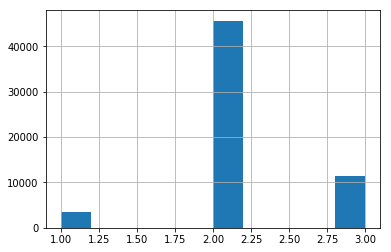

In [83]:
df_spark_final = df_spark_final.withColumn('age_bucket',fn.when(fn.col('age')<=40,1).otherwise(df_spark_final.age))
df_spark_final = df_spark_final.withColumn('age_bucket',fn.when(fn.col('age_bucket')>80,3).otherwise(df_spark_final.age_bucket))
df_spark_final = df_spark_final.withColumn('age_bucket',fn.when((fn.col('age_bucket')>40) & (fn.col('age_bucket')<=80),2).otherwise(df_spark_final.age_bucket))

df_spark_final.select('age_bucket').toPandas().age_bucket.hist()

In [84]:
df_spark_final.select('age','age_bucket','readmitted').toPandas().corr()

,age,age_bucket,readmitted
age,1.000000,0.797719,0.058053
age_bucket,0.797719,1.000000,0.038740
readmitted,0.058053,0.038740,1.000000


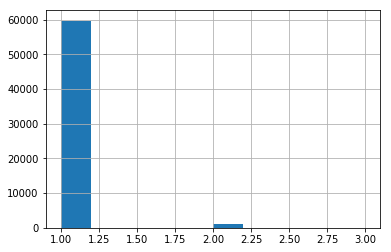

In [85]:
df_spark_final = df_spark_final.withColumn('total_visits_bucket',fn.when(fn.col('total_visits')<5,1).otherwise(df_spark_final.total_visits))
df_spark_final = df_spark_final.withColumn('total_visits_bucket',fn.when(fn.col('total_visits_bucket')>20,3).otherwise(df_spark_final.total_visits_bucket))
df_spark_final = df_spark_final.withColumn('total_visits_bucket',fn.when((fn.col('total_visits_bucket')>=5) & (fn.col('total_visits_bucket')<=20),2).otherwise(df_spark_final.total_visits_bucket))

df_spark_final.select('total_visits_bucket').toPandas().total_visits_bucket.hist()


In [86]:
df_spark_final.select('total_visits','total_visits_bucket','total_visits_log','total_visits_sqrt','readmitted').toPandas().corr()

,total_visits,total_visits_bucket,total_visits_log,total_visits_sqrt,readmitted
total_visits,1.000000,0.720493,0.756807,0.898427,0.126194
total_visits_bucket,0.720493,1.000000,0.331993,0.511074,0.062766
total_visits_log,0.756807,0.331993,1.000000,0.963438,0.152365
total_visits_sqrt,0.898427,0.511074,0.963438,1.000000,0.151869
readmitted,0.126194,0.062766,0.152365,0.151869,1.000000


In [87]:
df_spark_final = df_spark_final.withColumn('time_in_hospital_log',fn.round(fn.log(fn.col('time_in_hospital')+0.01),2))
df_spark_final = df_spark_final.withColumn('num_procedures_log',fn.round(fn.log(fn.col('num_procedures')+0.01),2))


In [88]:
df_spark_final.select('total_visits_log','time_in_hospital_log','number_emergency_log','num_procedures_log',
                     'num_lab_procedures_log','num_medications_log','number_diagnoses','readmitted').toPandas().corr()

,total_visits_log,time_in_hospital_log,number_emergency_log,num_procedures_log,num_lab_procedures_log,num_medications_log,number_diagnoses,readmitted
total_visits_log,1.000000,0.023855,0.191093,-0.021938,0.029233,0.063768,0.126473,0.152365
time_in_hospital_log,0.023855,1.000000,-0.003627,0.173800,0.250315,0.455073,0.249008,0.061952
number_emergency_log,0.191093,-0.003627,1.000000,-0.034472,0.019004,0.016358,0.063787,0.094342
num_procedures_log,-0.021938,0.173800,-0.034472,1.000000,-0.010507,0.348460,0.049456,-0.036523
num_lab_procedures_log,0.029233,0.250315,0.019004,-0.010507,1.000000,0.209743,0.100193,0.022031
num_medications_log,0.063768,0.455073,0.016358,0.348460,0.209743,1.000000,0.276383,0.051674
number_diagnoses,0.126473,0.249008,0.063787,0.049456,0.100193,0.276383,1.000000,0.105840
readmitted,0.152365,0.061952,0.094342,-0.036523,0.022031,0.051674,0.105840,1.000000


In [89]:
backup_omkar = df_spark_final

# PART 2 - Modeling

## Splitting Data into Training, Validation and Testing

In [2]:
#df_spark_final = spark.read.csv('new_final2_cleaned_df.csv',header=True)

In [90]:
training_df,validation_df,testing_df = df_spark_final.randomSplit([0.6, 0.3, 0.1], seed=0)
print("# points in training: ", training_df.count())
print("# points in validation: ", validation_df.count())
print("# points in testing: ", testing_df.count())

# points in training:  36502
# points in validation:  18232
# points in testing:  6001


In [91]:
# Checking if all the splits have equal proportion of readmitted patients
training_df.groupBy('readmitted').agg(fn.count('readmitted')).show()

+----------+-----------------+
|readmitted|count(readmitted)|
+----------+-----------------+
|         1|            14549|
|         0|            21953|
+----------+-----------------+



## Logistic Regression without Cross Validation

In [92]:
va = feature.VectorAssembler(inputCols=['time_in_hospital_log','number_emergency_log','total_visits_log','diabetesMed',
                                        'num_medications_log','dd_hhs','admission_source_emergency','dd_expired','insulin_index',
                                        'number_diagnoses','age'], outputCol='features')


lr = classification.LogisticRegression(labelCol='readmitted')
pipeline = Pipeline(stages=[va, lr])
model1 = pipeline.fit(training_df)


In [93]:
def binary_evaluation(model_pipeline,model_fitted,data):
    return BinaryClassificationEvaluator(labelCol=model_pipeline.getStages()[-1].getLabelCol(),
                                        rawPredictionCol=model_pipeline.getStages()[-1].getRawPredictionCol()).\
    evaluate(model_fitted.transform(data))

In [94]:
binary_evaluation(pipeline,model1,validation_df)

0.6309075513215597

In [148]:
predictions = model1.transform(validation_df)

In [150]:
predictions = predictions.withColumn('label',fn.col('readmitted'))

In [152]:
# Confusion matrix
tp = predictions[(predictions.label == 1) & (predictions.prediction == 1)].count()
tn = predictions[(predictions.label == 0) & (predictions.prediction == 0)].count()
fp = predictions[(predictions.label == 0) & (predictions.prediction == 1)].count()
fn = predictions[(predictions.label == 1) & (predictions.prediction == 0)].count()

In [153]:
print("True Positives:", tp)
print("True Negatives:", tn)
print("False Positives:", fp)
print("False Negatives:", fn)

True Positives: 1725
True Negatives: 9600
False Positives: 1386
False Negatives: 5521


## Logistic Regression with CV and Regularization

In [140]:
numerical_features = pipe(feature.VectorAssembler(inputCols=['time_in_hospital_log','number_emergency_log','total_visits_log',
                                        'num_medications_log','number_diagnoses','age']), feature.StandardScaler())


In [141]:
other_features = feature.VectorAssembler(inputCols=['dd_hhs','dd_expired','diabetesMed','insulin_index','admission_source_emergency'])


In [142]:
all_features = pipe((numerical_features, other_features), feature.VectorAssembler())
                    

In [143]:
lr = classification.LogisticRegression(labelCol='readmitted')

In [144]:
final_model_pipeline = pipe(all_features, lr)

In [145]:
paramGrid = ParamGridBuilder() \
    .addGrid(lr.elasticNetParam, [0.1,0.01]) \
    .build()

evaluator = BinaryClassificationEvaluator(labelCol=lr.getLabelCol(), rawPredictionCol=lr.getRawPredictionCol())
crossval = CrossValidator(estimator=final_model_pipeline, 
                          estimatorParamMaps=paramGrid, 
                          evaluator=evaluator, 
                          numFolds=3)


final_model_fitted = crossval.fit(training_df)

In [146]:
evaluator.evaluate(final_model_fitted.transform(validation_df))

0.6309075513215601

In [147]:
final_model_fitted.bestModel.stages[-1].coefficients

DenseVector([0.0572, 0.1386, 0.2623, 0.0134, 0.1356, 0.1042, 0.1021, -20.4713, 0.2101, 0.0122, 0.2424])

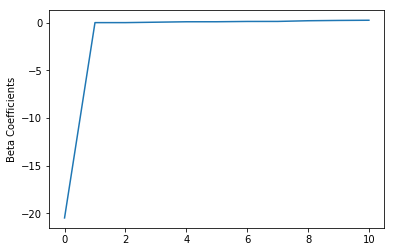

In [105]:
beta = np.sort(final_model_fitted.bestModel.stages[-1].coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

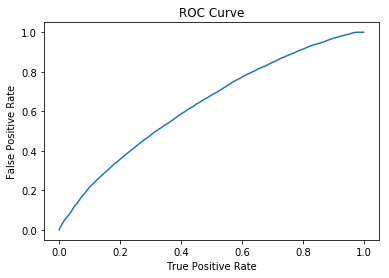

Training set areaUnderROC: 0.6345300694364213


In [106]:
trainingSummary = final_model_fitted.bestModel.stages[-1].summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

In [225]:
predictions = final_model_fitted.bestModel.transform(validation_df)

In [227]:
predictions = predictions.withColumn('rawPrediction',fn.col('LogisticRegression_4560806910180b46e75c__rawPrediction'))

In [230]:
predictions = predictions.withColumn('label',fn.col('readmitted'))

In [231]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.6309075513215602


In [234]:
# Confusion matrix
tp = predictions[(predictions.label == 1) & (predictions.LogisticRegression_4560806910180b46e75c__prediction == 1)].count()
tn = predictions[(predictions.label == 0) & (predictions.LogisticRegression_4560806910180b46e75c__prediction == 0)].count()
fp = predictions[(predictions.label == 0) & (predictions.LogisticRegression_4560806910180b46e75c__prediction == 1)].count()
fn = predictions[(predictions.label == 1) & (predictions.LogisticRegression_4560806910180b46e75c__prediction == 0)].count()

In [235]:
print("True Positives:", tp)
print("True Negatives:", tn)
print("False Positives:", fp)
print("False Negatives:", fn)

True Positives: 1725
True Negatives: 9600
False Positives: 1386
False Negatives: 5521


# Gradient Boosting 

In [107]:
training_df = training_df.withColumn('label',fn.col('readmitted'))

In [283]:
va = feature.VectorAssembler(inputCols=['time_in_hospital_log','number_emergency_log','total_visits_log','diabetesMed',
                                        'num_medications_log','dd_hhs','admission_source_emergency','dd_expired','insulin_index',
                                        'number_diagnoses','age'], outputCol='features')


gbt = GBTClassifier(labelCol='readmitted')
pipeline = Pipeline(stages=[va, gbt])
model_gbt = pipeline.fit(training_df)


In [284]:
predictions_gbt = model_gbt.transform(validation_df)

In [285]:
predictions_gbt = predictions_gbt.withColumn('label',fn.col('readmitted'))

In [286]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions_gbt, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.6364019102122748


## GBT with cross-val

In [154]:
numerical_features = \
    pipe(feature.VectorAssembler(inputCols=['total_visits_log','time_in_hospital_log','number_emergency_log','num_procedures_log',
'num_lab_procedures_log','num_medications_log','number_diagnoses','age']),\
                            feature.StandardScaler())

other_features= feature.VectorAssembler(inputCols=['admission_source_phyref','admission_source_cliref',
'admission_source_hmoref','admission_source_hos','admission_source_snf',
'admission_source_hlthcare','admission_source_emergency', 'admission_source_court', 'admission_source_critical',
'admission_source_normdel', 'admission_source_birth', 'admission_source_surgery',
'dd_home','dd_shortm_hos','dd_snf','AfricanAmerican','Asian','Caucasian','Hispanic','dd_icf',
'dd_careInst','dd_hhs','dd_ama','dd_homeIvy','dd_admInp','dd_expired','dd_hospice',
'dd_medfac','dd_swingbed','dd_rehab','dd_long','dd_nursing','dd_federal','dd_psy','diag1_Circulatory',
'diag1_Respiratory','diag1_Digestive','diag1_Diabetes',
'diag1_Injury','diag1_Musculoskeletal','diag1_Genitourinary','diag1_Neoplasms',
'diag2_Circulatory','diag2_Respiratory','diag2_Digestive','diag2_Diabetes','diag2_Injury','diag2_Musculoskeletal',
'diag2_Genitourinary','diag2_Neoplasms','diag3_Circulatory','diag3_Respiratory','diag3_Digestive',
'diag3_Diabetes','diag3_Injury','diag3_Musculoskeletal','diag3_Genitourinary','diag3_Neoplasms',
'max_glu_200','max_glu_300','max_glu_norm','A1Cresult_7','A1Cresult_8','A1Cresult_norm',
'metformin_index','repaglinide_index','nateglinide_index','chlorpropamide_index','glimepiride_index',
'acetohexamide_index','troglitazone_index','tolazamide_index','glyburide-metformin_index',
'glipizide-metformin_index','glimepiride-pioglitazone_index','metformin-rosiglitazone_index',
'metformin-pioglitazone_index','glipizide_index','glyburide_index','tolbutamide_index','pioglitazone_index',
'rosiglitazone_index','acarbose_index','insulin_index','miglitol_index'])

all_features = pipe((numerical_features,other_features), feature.VectorAssembler())

gbt = GBTClassifier(labelCol='readmitted')

final_model_pipeline = pipe(all_features, gbt)

paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxDepth, [4, 6]) \
    .addGrid(gbt.maxBins, [20, 40]) \
    .addGrid(gbt.maxIter, [10, 20]) \
    .build()

evaluator = BinaryClassificationEvaluator()
cv = CrossValidator(estimator=final_model_pipeline, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=3)



In [157]:
cvModel = cv.fit(training_df)

In [156]:
print('Hi')

Hi


In [158]:
predictions_gbt2 = cvModel.transform(validation_df)

In [161]:
predictions_gbt2 = predictions_gbt2.withColumn('label',predictions_gbt2.readmitted)

In [162]:
evaluator.evaluate(predictions_gbt2)

0.64342428466029

In [164]:
# Confusion matrix
tp = predictions_gbt2[(predictions_gbt2.label == 1) & (predictions_gbt2.GBTClassifier_4f81a4e992a272367351__prediction == 1)].count()
tn = predictions_gbt2[(predictions_gbt2.label == 0) & (predictions_gbt2.GBTClassifier_4f81a4e992a272367351__prediction == 0)].count()
fp = predictions_gbt2[(predictions_gbt2.label == 0) & (predictions_gbt2.GBTClassifier_4f81a4e992a272367351__prediction == 1)].count()
fn = predictions_gbt2[(predictions_gbt2.label == 1) & (predictions_gbt2.GBTClassifier_4f81a4e992a272367351__prediction == 0)].count()


In [165]:
print("True Positives:", tp)
print("True Negatives:", tn)
print("False Positives:", fp)
print("False Negatives:", fn)

True Positives: 1994
True Negatives: 9452
False Positives: 1534
False Negatives: 5252


In [ ]:
## Testing Gradient Boosting 

## Neural Networks

In [108]:
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [109]:
# specify layers for the neural network:
# input layer of size 4 (features), two intermediate of size 5 and 4
# and output of size 3 (classes)
layers = [10,4,2]

In [110]:
va = feature.VectorAssembler(inputCols=['total_visits_log','time_in_hospital_log','number_emergency_log','num_procedures_log',
                     'num_lab_procedures_log','num_medications_log','number_diagnoses','dd_hhs','dd_expired','insulin_index',
                                        ], outputCol='features')


# create the trainer and set its parameters
neural = MultilayerPerceptronClassifier(maxIter=100, layers=layers, blockSize=128, seed=1234)

pipeline = Pipeline(stages=[va, neural])
model_neural = pipeline.fit(training_df)


In [111]:
# compute accuracy on the test set
result_neural = model_neural.transform(validation_df)
result_neural = result_neural.withColumn('label',fn.col('readmitted'))
predictionAndLabels = result_neural.select("prediction", "label")

In [112]:
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
print("Validation set accuracy = " + str(evaluator.evaluate(predictionAndLabels)))

Validation set accuracy = 0.6199539271610356


## Gradient Boosting with all features

In [134]:
va = feature.VectorAssembler(inputCols=['total_visits_log','time_in_hospital_log','number_emergency_log','num_procedures_log',
'num_lab_procedures_log','num_medications_log','number_diagnoses','admission_source_phyref','admission_source_cliref',
'admission_source_hmoref','admission_source_hos','admission_source_snf',
'admission_source_hlthcare','admission_source_emergency', 'admission_source_court', 'admission_source_critical',
'admission_source_normdel', 'admission_source_birth', 'admission_source_surgery','age',
'dd_home','dd_shortm_hos','dd_snf','AfricanAmerican','Asian','Caucasian','Hispanic','dd_icf',
'dd_careInst','dd_hhs','dd_ama','dd_homeIvy','dd_admInp','dd_expired','dd_hospice',
'dd_medfac','dd_swingbed','dd_rehab','dd_long','dd_nursing','dd_federal','dd_psy','diag1_Circulatory',
'diag1_Respiratory','diag1_Digestive','diag1_Diabetes',
'diag1_Injury','diag1_Musculoskeletal','diag1_Genitourinary','diag1_Neoplasms',
'diag2_Circulatory','diag2_Respiratory','diag2_Digestive','diag2_Diabetes','diag2_Injury','diag2_Musculoskeletal',
'diag2_Genitourinary','diag2_Neoplasms','diag3_Circulatory','diag3_Respiratory','diag3_Digestive',
'diag3_Diabetes','diag3_Injury','diag3_Musculoskeletal','diag3_Genitourinary','diag3_Neoplasms',
'max_glu_200','max_glu_300','max_glu_norm','A1Cresult_7','A1Cresult_8','A1Cresult_norm',
'metformin_index','repaglinide_index','nateglinide_index','chlorpropamide_index','glimepiride_index',
'acetohexamide_index','troglitazone_index','tolazamide_index','glyburide-metformin_index',
'glipizide-metformin_index','glimepiride-pioglitazone_index','metformin-rosiglitazone_index',
'metformin-pioglitazone_index','glipizide_index','glyburide_index','tolbutamide_index','pioglitazone_index',
'rosiglitazone_index','acarbose_index','insulin_index','miglitol_index'], outputCol='features')


gbt = GBTClassifier(labelCol='readmitted')
pipeline = Pipeline(stages=[va, gbt])
model_gbt = pipeline.fit(training_df)
predictions_gbt = model_gbt.transform(validation_df)

predictions_gbt = predictions_gbt.withColumn('label',fn.col('readmitted'))

evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions_gbt, {evaluator.metricName: "areaUnderROC"})))


Test Area Under ROC: 0.6442514923392071


## Neural Networks with all features

In [180]:
# specify layers for the neural network:
# input layer of size 4 (features), two intermediate of size 5 and 4
# and output of size 3 (classes)
layers = [93,8,2]

In [181]:
va = feature.VectorAssembler(inputCols=['total_visits_log','time_in_hospital_log','number_emergency_log','num_procedures_log',
'num_lab_procedures_log','num_medications_log','number_diagnoses','admission_source_phyref','admission_source_cliref',
'admission_source_hmoref','admission_source_hos','admission_source_snf',
'admission_source_hlthcare','admission_source_emergency', 'admission_source_court', 'admission_source_critical',
'admission_source_normdel', 'admission_source_birth', 'admission_source_surgery','age',
'dd_home','dd_shortm_hos','dd_snf','AfricanAmerican','Asian','Caucasian','Hispanic','dd_icf',
'dd_careInst','dd_hhs','dd_ama','dd_homeIvy','dd_admInp','dd_expired','dd_hospice',
'dd_medfac','dd_swingbed','dd_rehab','dd_long','dd_nursing','dd_federal','dd_psy','diag1_Circulatory',
'diag1_Respiratory','diag1_Digestive','diag1_Diabetes',
'diag1_Injury','diag1_Musculoskeletal','diag1_Genitourinary','diag1_Neoplasms',
'diag2_Circulatory','diag2_Respiratory','diag2_Digestive','diag2_Diabetes','diag2_Injury','diag2_Musculoskeletal',
'diag2_Genitourinary','diag2_Neoplasms','diag3_Circulatory','diag3_Respiratory','diag3_Digestive',
'diag3_Diabetes','diag3_Injury','diag3_Musculoskeletal','diag3_Genitourinary','diag3_Neoplasms',
'max_glu_200','max_glu_300','max_glu_norm','A1Cresult_7','A1Cresult_8','A1Cresult_norm',
'metformin_index','repaglinide_index','nateglinide_index','chlorpropamide_index','glimepiride_index',
'acetohexamide_index','troglitazone_index','tolazamide_index','glyburide-metformin_index',
'glipizide-metformin_index','glimepiride-pioglitazone_index','metformin-rosiglitazone_index',
'metformin-pioglitazone_index','glipizide_index','glyburide_index','tolbutamide_index','pioglitazone_index',
'rosiglitazone_index','acarbose_index','insulin_index','miglitol_index'
                                        ], outputCol='features')


# create the trainer and set its parameters
neural = MultilayerPerceptronClassifier(maxIter=200, layers=layers, blockSize=128, seed=1234)

pipeline = Pipeline(stages=[va, neural])
model_neural = pipeline.fit(training_df)


In [182]:
# compute accuracy on the test set
result_neural = model_neural.transform(validation_df)
result_neural = result_neural.withColumn('label',result_neural.readmitted)
predictionAndLabels = result_neural.select("prediction", "label")
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
print("Validation set accuracy = " + str(evaluator.evaluate(predictionAndLabels)))

Validation set accuracy = 0.6223672663448881


In [184]:
# Confusion matrix
tp = result_neural[(result_neural.label == 1) & (result_neural.prediction == 1)].count()
tn = result_neural[(result_neural.label == 0) & (result_neural.prediction == 0)].count()
fp = result_neural[(result_neural.label == 0) & (result_neural.prediction == 1)].count()
fn = result_neural[(result_neural.label == 1) & (result_neural.prediction == 0)].count()


In [185]:
print("True Positives:", tp)
print("True Negatives:", tn)
print("False Positives:", fp)
print("False Negatives:", fn)

True Positives: 1453
True Negatives: 9894
False Positives: 1092
False Negatives: 5793


## Random Forest with all features

In [116]:
va = feature.VectorAssembler(inputCols=['total_visits_log','time_in_hospital_log','number_emergency_log','num_procedures_log',
'num_lab_procedures_log','num_medications_log','number_diagnoses','admission_source_phyref','admission_source_cliref',
'admission_source_hmoref','admission_source_hos','admission_source_snf',
'admission_source_hlthcare','admission_source_emergency', 'admission_source_court', 'admission_source_critical',
'admission_source_normdel', 'admission_source_birth', 'admission_source_surgery','age',
'dd_home','dd_shortm_hos','dd_snf','AfricanAmerican','Asian','Caucasian','Hispanic','dd_icf',
'dd_careInst','dd_hhs','dd_ama','dd_homeIvy','dd_admInp','dd_expired','dd_hospice',
'dd_medfac','dd_swingbed','dd_rehab','dd_long','dd_nursing','dd_federal','dd_psy','diag1_Circulatory',
'diag1_Respiratory','diag1_Digestive','diag1_Diabetes',
'diag1_Injury','diag1_Musculoskeletal','diag1_Genitourinary','diag1_Neoplasms',
'diag2_Circulatory','diag2_Respiratory','diag2_Digestive','diag2_Diabetes','diag2_Injury','diag2_Musculoskeletal',
'diag2_Genitourinary','diag2_Neoplasms','diag3_Circulatory','diag3_Respiratory','diag3_Digestive',
'diag3_Diabetes','diag3_Injury','diag3_Musculoskeletal','diag3_Genitourinary','diag3_Neoplasms',
'max_glu_200','max_glu_300','max_glu_norm','A1Cresult_7','A1Cresult_8','A1Cresult_norm',
'metformin_index','repaglinide_index','nateglinide_index','chlorpropamide_index','glimepiride_index',
'acetohexamide_index','troglitazone_index','tolazamide_index','glyburide-metformin_index',
'glipizide-metformin_index','glimepiride-pioglitazone_index','metformin-rosiglitazone_index',
'metformin-pioglitazone_index','glipizide_index','glyburide_index','tolbutamide_index','pioglitazone_index',
'rosiglitazone_index','acarbose_index','insulin_index','miglitol_index'], outputCol='features')


rf = classification.RandomForestClassifier(labelCol='readmitted',numTrees=10)

final_model_pipeline = Pipeline(stages=[va, rf])

final_model_fitted = final_model_pipeline.fit(training_df)


In [117]:
binary_evaluation(final_model_pipeline,final_model_fitted,validation_df)

0.6320045299919769

## Random Forest with all features with Cross-Validation

In [ ]:
numerical_features = \
    pipe(feature.VectorAssembler(inputCols=['total_visits_log','time_in_hospital_log','number_emergency_log','num_procedures_log',
'num_lab_procedures_log','num_medications_log','number_diagnoses','age']),\
                            feature.StandardScaler())

other_features= feature.VectorAssembler(inputCols=['admission_source_phyref','admission_source_cliref',
'admission_source_hmoref','admission_source_hos','admission_source_snf',
'admission_source_hlthcare','admission_source_emergency', 'admission_source_court', 'admission_source_critical',
'admission_source_normdel', 'admission_source_birth', 'admission_source_surgery',
'dd_home','dd_shortm_hos','dd_snf','AfricanAmerican','Asian','Caucasian','Hispanic','dd_icf',
'dd_careInst','dd_hhs','dd_ama','dd_homeIvy','dd_admInp','dd_expired','dd_hospice',
'dd_medfac','dd_swingbed','dd_rehab','dd_long','dd_nursing','dd_federal','dd_psy','diag1_Circulatory',
'diag1_Respiratory','diag1_Digestive','diag1_Diabetes',
'diag1_Injury','diag1_Musculoskeletal','diag1_Genitourinary','diag1_Neoplasms',
'diag2_Circulatory','diag2_Respiratory','diag2_Digestive','diag2_Diabetes','diag2_Injury','diag2_Musculoskeletal',
'diag2_Genitourinary','diag2_Neoplasms','diag3_Circulatory','diag3_Respiratory','diag3_Digestive',
'diag3_Diabetes','diag3_Injury','diag3_Musculoskeletal','diag3_Genitourinary','diag3_Neoplasms',
'max_glu_200','max_glu_300','max_glu_norm','A1Cresult_7','A1Cresult_8','A1Cresult_norm',
'metformin_index','repaglinide_index','nateglinide_index','chlorpropamide_index','glimepiride_index',
'acetohexamide_index','troglitazone_index','tolazamide_index','glyburide-metformin_index',
'glipizide-metformin_index','glimepiride-pioglitazone_index','metformin-rosiglitazone_index',
'metformin-pioglitazone_index','glipizide_index','glyburide_index','tolbutamide_index','pioglitazone_index',
'rosiglitazone_index','acarbose_index','insulin_index','miglitol_index'
                                        ])

all_features = pipe((numerical_features,other_features), feature.VectorAssembler())

rf = classification.RandomForestClassifier(labelCol='readmitted',numTrees=10)

final_model_pipeline = pipe(all_features, rf)

paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10]) \
    .build()
crossval = CrossValidator(estimator=final_model_pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(labelCol=rf.getLabelCol(),rawPredictionCol=rf.getRawPredictionCol()),
                          numFolds=2) 

# Run cross-validation, and choose the best set of parameters.
cvModel_fitted = crossval.fit(training_df)

## Heat Map

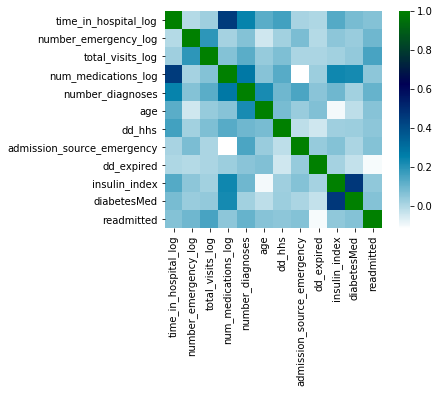

In [133]:
# corr_matrix = df_spark_final.select('time_in_hospital_log','number_emergency_log','total_visits_log',
#                                         'num_medications_log','number_diagnoses','age','dd_hhs',
#                                     'admission_source_emergency','dd_expired','insulin_index','diabetesMed','readmitted')

# pd_corr = corr_matrix.toPandas()

sns.heatmap(pd_corr.corr(),square=True,cmap='ocean_r')

# Extra

In [55]:
#df_spark_final.coalesce(1).write.csv('final_file_20Nov.csv',header=True)

In [57]:
training_df.select('AfricanAmerican','Asian','Caucasian','Hispanic','readmitted').toPandas().corr()

,AfricanAmerican,Asian,Caucasian,Hispanic,readmitted
AfricanAmerican,1.000000,-0.041724,-0.877588,-0.070015,-0.016258
Asian,-0.041724,1.000000,-0.152646,-0.012178,-0.014440
Caucasian,-0.877588,-0.152646,1.000000,-0.256147,0.031465
Hispanic,-0.070015,-0.012178,-0.256147,1.000000,-0.024909
readmitted,-0.016258,-0.014440,0.031465,-0.024909,1.000000


## Best features after EDA

In [60]:
# training_df.select('time_in_hospital','number_emergency_log',
#                                          'total_visits_log',
#                                          'number_diagnoses','age','glipizide_index','glyburide_index','insulin_index',
#                    'Caucasian','Asian','AfricanAmerican','diag1_Circulatory','diag2_Circulatory','diag3_Circulatory',
#                    'diag1_Diabetes','diag2_Diabetes','diag3_Diabetes','age','admission_source_id','admission_type_id',
#                    'num_lab_procedures','readmitted').toPandas().corr()

In [59]:
training_df.select('time_in_hospital','number_emergency_log','num_procedures','num_lab_procedures',
                                         'total_visits_log','num_medications',
                                         'number_diagnoses','age','admission_source_id','discharge_disposition_id',
                'admission_type_id','readmitted').toPandas().corr()



,time_in_hospital,number_emergency_log,num_procedures,num_lab_procedures,total_visits_log,num_medications,number_diagnoses,age,admission_source_id,discharge_disposition_id,admission_type_id,readmitted
time_in_hospital,1.000000,0.001962,0.183869,0.340074,0.028749,0.466317,0.228444,0.119593,0.026051,0.183079,-0.020701,0.053490
number_emergency_log,0.001962,1.000000,-0.044981,0.034975,0.195497,0.011868,0.070623,-0.045093,0.065733,-0.033569,-0.044051,0.099970
num_procedures,0.183869,-0.044981,1.000000,0.025742,-0.042134,0.398548,0.058333,-0.034590,-0.221829,0.026855,0.257048,-0.035525
num_lab_procedures,0.340074,0.034975,0.025742,1.000000,0.047090,0.263186,0.169331,0.040275,0.259396,0.039871,-0.282436,0.037499
total_visits_log,0.028749,0.195497,-0.042134,0.047090,1.000000,0.043008,0.124229,0.040916,-0.007898,-0.037566,-0.016934,0.153951
num_medications,0.466317,0.011868,0.398548,0.263186,0.043008,1.000000,0.233225,0.033155,-0.141091,0.139293,0.166752,0.027315
number_diagnoses,0.228444,0.070623,0.058333,0.169331,0.124229,0.233225,1.000000,0.212787,0.123196,0.040118,-0.109210,0.106221
age,0.119593,-0.045093,-0.034590,0.040275,0.040916,0.033155,0.212787,1.000000,0.049896,0.129961,-0.044088,0.062097
admission_source_id,0.026051,0.065733,-0.221829,0.259396,-0.007898,-0.141091,0.123196,0.049896,1.000000,-0.006267,-0.789093,0.046929
discharge_disposition_id,0.183079,-0.033569,0.026855,0.039871,-0.037566,0.139293,0.040118,0.129961,-0.006267,1.000000,0.013801,-0.016540


In [85]:
# sns.heatmap(training_df.select('admission_source_id','time_in_hospital','number_emergency_log',
#                                         'total_visits_log','num_procedures','num_medications',
#                                         'number_diagnoses','num_lab_procedures','age','readmitted').toPandas().corr(),square=True,cmap='RdYlGn')

In [69]:
# training_df.select('metformin_index','glipizide_index','glimepiride_index',
#       'glyburide_index','rosiglitazone_index','insulin_index','readmitted').toPandas().corr()

,metformin_index,glipizide_index,glimepiride_index,glyburide_index,rosiglitazone_index,insulin_index,readmitted
metformin_index,1.000000,0.070103,0.040839,0.142588,0.100818,-0.015594,-0.013139
glipizide_index,0.070103,1.000000,-0.064131,-0.093282,0.052849,-0.019949,0.034719
glimepiride_index,0.040839,-0.064131,1.000000,-0.064650,0.043464,0.005651,0.005451
glyburide_index,0.142588,-0.093282,-0.064650,1.000000,0.035099,-0.068701,0.021065
rosiglitazone_index,0.100818,0.052849,0.043464,0.035099,1.000000,0.009501,0.013638
insulin_index,-0.015594,-0.019949,0.005651,-0.068701,0.009501,1.000000,0.042633
readmitted,-0.013139,0.034719,0.005451,0.021065,0.013638,0.042633,1.000000


In [70]:
# training_df.select('diag1_Circulatory',
#  'diag1_Respiratory',
#  'diag1_Digestive',
#  'diag1_Diabetes',
#  'diag1_Injury',
#  'diag1_Musculoskeletal',
#  'diag1_Genitourinary',
#  'diag1_Neoplasms',
#  'diag2_Circulatory',
#  'diag2_Respiratory',
#  'diag2_Digestive',
#  'diag2_Diabetes',
#  'diag2_Injury',
#  'diag2_Musculoskeletal',
#  'diag2_Genitourinary',
#  'diag2_Neoplasms',
#  'diag3_Circulatory',
#  'diag3_Respiratory',
#  'diag3_Digestive',
#  'diag3_Diabetes',
#  'diag3_Injury',
#  'diag3_Musculoskeletal',
#  'diag3_Genitourinary',
#  'diag3_Neoplasms','readmitted').toPandas().corr()

,diag1_Circulatory,diag1_Respiratory,diag1_Digestive,diag1_Diabetes,diag1_Injury,diag1_Musculoskeletal,diag1_Genitourinary,diag1_Neoplasms,diag2_Circulatory,diag2_Respiratory,...,diag2_Neoplasms,diag3_Circulatory,diag3_Respiratory,diag3_Digestive,diag3_Diabetes,diag3_Injury,diag3_Musculoskeletal,diag3_Genitourinary,diag3_Neoplasms,readmitted
diag1_Circulatory,1.000000,-0.278460,-0.221717,-0.198651,-0.170360,-0.170220,-0.161744,-0.282367,0.308351,-0.005950,...,-0.163392,0.179697,0.016222,-0.082717,0.014107,-0.030894,-0.054365,-0.029785,-0.090995,0.025760
diag1_Respiratory,-0.278460,1.000000,-0.129013,-0.115591,-0.099129,-0.099048,-0.094116,-0.164304,-0.015104,0.170022,...,-0.034648,0.007101,0.060285,-0.026035,0.033405,-0.035510,-0.011786,-0.028281,-0.017077,0.009786
diag1_Digestive,-0.221717,-0.129013,1.000000,-0.092037,-0.078929,-0.078865,-0.074938,-0.130823,-0.100291,-0.032419,...,-0.006045,-0.053834,-0.012926,0.163856,0.007138,-0.017593,-0.026875,-0.017307,-0.005625,-0.007412
diag1_Diabetes,-0.198651,-0.115591,-0.092037,1.000000,-0.070718,-0.070660,-0.067142,-0.117213,-0.065555,-0.046247,...,0.202947,-0.051225,-0.025911,0.023712,-0.117463,-0.017863,0.055043,0.004165,0.140165,0.018972
diag1_Injury,-0.170360,-0.099129,-0.078929,-0.070718,1.000000,-0.060597,-0.057580,-0.100520,-0.035107,-0.031420,...,-0.006170,-0.018459,-0.009741,-0.020995,-0.007143,0.145313,0.002127,0.006733,-0.011293,-0.010670
diag1_Musculoskeletal,-0.170220,-0.099048,-0.078865,-0.070660,-0.060597,1.000000,-0.057533,-0.100438,-0.041063,-0.024767,...,-0.044866,-0.019570,-0.032765,-0.018380,0.053951,0.018579,0.118719,-0.024042,-0.031186,-0.017081
diag1_Genitourinary,-0.161744,-0.094116,-0.074938,-0.067142,-0.057580,-0.057533,1.000000,-0.095437,-0.069233,-0.041671,...,0.088544,-0.042303,-0.018987,-0.014998,-0.014590,-0.017356,-0.013060,0.097957,0.038745,-0.011435
diag1_Neoplasms,-0.282367,-0.164304,-0.130823,-0.117213,-0.100520,-0.100438,-0.095437,1.000000,-0.113004,-0.011311,...,0.097464,-0.068348,-0.001198,0.012413,-0.010803,0.021380,-0.004738,0.042839,0.058498,-0.017050
diag2_Circulatory,0.308351,-0.015104,-0.100291,-0.065555,-0.035107,-0.041063,-0.069233,-0.113004,1.000000,-0.242694,...,-0.336879,0.094604,0.018212,-0.072718,0.105156,-0.025680,-0.048670,-0.008204,-0.091534,0.032051
diag2_Respiratory,-0.005950,0.170022,-0.032419,-0.046247,-0.031420,-0.024767,-0.041671,-0.011311,-0.242694,1.000000,...,-0.166809,0.010562,0.073505,-0.021990,-0.004814,-0.014416,-0.008297,-0.014752,-0.015389,0.002907


In [ ]:
# time_in_hospital','number_emergency_log',
#                           'total_visits_log',
#                   'number_diagnoses','age','glipizide_index','glyburide_index','insulin_index',
#    'Caucasian','Asian','AfricanAmerican','diag1_Circulatory','diag2_Circulatory','diag3_Circulatory',
#    'diag1_Diabetes','diag2_Diabetes','diag3_Diabetes','age','admission_source_id','admission_type_id',
#        'num_lab_procedures','readmitted'

training_df.select('admission_sor').show(5)

## Logistic Regression without Cross Validation

In [76]:
va = feature.VectorAssembler(inputCols=['time_in_hospital','number_emergency_log','total_visits_log',
                                        'number_diagnoses','age','admission_type_id','admission_source_id',
                                        'num_lab_procedures'], outputCol='features')
Stdscaler = StandardScaler(inputCol="features", outputCol="scaledFeatures",
                        withStd=True, withMean=False)

lr = classification.LogisticRegression(labelCol='readmitted',maxIter=5,featuresCol="scaledFeatures")
pipeline = Pipeline(stages=[va,Stdscaler, lr])

model1 = pipeline.fit(training_df)



In [80]:
def binary_evaluation(model_pipeline,model_fitted,data):
    return BinaryClassificationEvaluator(labelCol=model_pipeline.getStages()[-1].getLabelCol(),
                                        rawPredictionCol=model_pipeline.getStages()[-1].getRawPredictionCol()).\
    evaluate(model_fitted.transform(data))

In [81]:
binary_evaluation(pipeline,model1,validation_df)

0.6071212934093873

In [83]:
va = feature.VectorAssembler(inputCols=['time_in_hospital','number_emergency_log','total_visits_log',
                                        'number_diagnoses','age','admission_type_id','admission_source_id',
                                        'num_lab_procedures'], outputCol='features')
Stdscaler = StandardScaler(inputCol="features", outputCol="scaledFeatures",
                        withStd=True, withMean=False)

lr = classification.LogisticRegression(labelCol='readmitted',maxIter=5,featuresCol="scaledFeatures")
pipeline2 = Pipeline(stages=[va,Stdscaler, lr])

paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.5,0.1,0.01]) \
    .addGrid(lr.elasticNetParam, [0.5,0.1, 0.01]) \
    .build()

crossval = CrossValidator(estimator=pipeline2,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(labelCol=lr.getLabelCol(),rawPredictionCol=lr.getRawPredictionCol()),
                          numFolds=5) 

# Run cross-validation, and choose the best set of parameters.
cvModel_fitted = crossval.fit(training_df)


In [84]:
binary_evaluation(pipeline2,cvModel_fitted,validation_df)

0.6059146916163947

In [96]:
!pip install git+https://github.com/daniel-acuna/pyspark_pipes.git
from pyspark_pipes import pipe

  Cloning https://github.com/daniel-acuna/pyspark_pipes.git to /tmp/pip-sxp3k32w-build
  Using cached https://files.pythonhosted.org/packages/e3/53/c737818eb9a7dc32a7cd4f1396e787bd94200c3997c72c1dbe028587bd76/py4j-0.10.7-py2.py3-none-any.whl
  Running setup.py install for pyspark-pipes ... done
You are using pip version 9.0.3, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [87]:
numerical_features = \
    pipe(feature.VectorAssembler(inputCols=['time_in_hospital','number_emergency_log','total_visits_log',\
                                       'number_diagnoses','age','admission_source_id','admission_type_id','num_lab_procedures']),\
                            feature.StandardScaler())

other_features= feature.VectorAssembler(inputCols=['glipizide_index','glyburide_index','insulin_index',
'Caucasian','Asian','AfricanAmerican','diag1_Circulatory','diag2_Circulatory','diag3_Circulatory',
'diag1_Diabetes','diag2_Diabetes','diag3_Diabetes'])


all_features = pipe((numerical_features,other_features), feature.VectorAssembler())

lr3 = classification.LogisticRegression(labelCol='readmitted')

final_model_pipeline = pipe(all_features, lr3)

final_model_fitted = final_model_pipeline.fit(training_df)

In [88]:
binary_evaluation(final_model_pipeline,final_model_fitted,validation_df)

0.616488470835765

In [91]:
numerical_features = \
    pipe(feature.VectorAssembler(inputCols=['time_in_hospital','number_emergency_log','total_visits_log',
                                       'number_diagnoses','age','num_procedures','num_medications']),\
                            feature.StandardScaler())

other_features= feature.VectorAssembler(inputCols=['glyburide_index','insulin_index','dd_shortm_hos',
'Caucasian'])


all_features = pipe((numerical_features,other_features), feature.VectorAssembler())

lr4 = classification.LogisticRegression(labelCol='readmitted')

final_model_pipeline = pipe(all_features, lr4)

final_model_fitted = final_model_pipeline.fit(training_df)

In [92]:
binary_evaluation(final_model_pipeline,final_model_fitted,validation_df)

0.6101075734911454

In [93]:
numerical_features = \
    pipe(feature.VectorAssembler(inputCols=['time_in_hospital','number_emergency_log','total_visits_log',
                                       'number_diagnoses','age','num_procedures','num_medications']),\
                            feature.StandardScaler())

other_features= feature.VectorAssembler(inputCols=['glyburide_index','insulin_index','dd_shortm_hos',
'Caucasian'])

all_features = pipe((numerical_features,other_features), feature.VectorAssembler())

rf = classification.RandomForestClassifier(labelCol='readmitted',numTrees=10)

final_model_pipeline = pipe(all_features, rf)

final_model_fitted = final_model_pipeline.fit(training_df)

In [94]:
binary_evaluation(final_model_pipeline,final_model_fitted,validation_df)

0.6131295864523129

In [107]:
numerical_features = \
    (feature.VectorAssembler(inputCols=['time_in_hospital','number_emergency_log','total_visits_log',\
                                       'number_diagnoses','age','num_lab_procedures']))

other_features= feature.VectorAssembler(inputCols=['glipizide_index','glyburide_index','insulin_index',
'Caucasian','Asian','AfricanAmerican','diag1_Circulatory','diag2_Circulatory','diag3_Circulatory',
'diag1_Diabetes','diag2_Diabetes','diag3_Diabetes'])

rf = classification.RandomForestClassifier(labelCol='readmitted',numTrees=10)

final_model_pipeline = pipe(numerical_features,other_features, rf)

final_model_fitted = final_model_pipeline.fit(training_df)

In [108]:
binary_evaluation(final_model_pipeline,final_model_fitted,validation_df)

0.5575500728877879

In [205]:
from pyspark.mllib.classification import LogisticRegressionWithLBFGS
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.mllib.util import MLUtils
from pyspark.mllib.evaluation import MulticlassMetrics

In [117]:
trainingSummary = model1.stages[-1].summary
trainingSummary.roc.show()
print("areaUnderROC: " + str(trainingSummary.areaUnderROC))

+--------------------+--------------------+
|                 FPR|                 TPR|
+--------------------+--------------------+
|                 0.0|                 0.0|
|0.001548763266979...|0.006804591380850917|
|0.004646289800938368| 0.01388411574678672|
|0.006741675397439985|0.020413774142552753|
| 0.00920147588028971|   0.027630765001031|
|0.011706828223932948| 0.03484775585950924|
|0.014212180567576185| 0.04055261530002062|
| 0.01667198105042591| 0.04577634201663344|
|0.019131781533275636|0.052099800673585814|
|0.021819341320092927| 0.05821705959172452|
|0.024734660410877785| 0.06371571929342223|
|0.028743224160706966| 0.06900817925630627|
|0.031658543251491825| 0.07430063921919032|
| 0.03507493281100533|  0.0809677641074988|
| 0.03867352981369289| 0.08722248951817994|
| 0.04122443401812964| 0.09402708089903086|
| 0.04441306427367558| 0.10028180630971201|
| 0.04796610941556963| 0.10578046601140972|
| 0.05120029153190908| 0.11127912571310743|
|0.054616681091422585| 0.1165028